In [1]:
# magic incantation to make the notebook wider
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important; }</style>")

#magic incantation to make all text in LaTeX font:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)

In [3]:
import numpy as np
import pylab as pl
import os, sys
%matplotlib inline

import new_functions as fn
fn = reload(fn)

In [4]:
# RUN = 10
RUN = 21

if RUN == 10:
    beam_mon_file = '/Users/mfisherlevine/Desktop/desy/RUN10.txt'
    timepix_data_dir = '/Users/mfisherlevine/Desktop/desy/Data/Run10/'
    MCP_file = ''
elif RUN ==21:
    beam_mon_file = '/Users/mfisherlevine/Desktop/desy/RUN21.txt'
    timepix_data_dir = '/Users/mfisherlevine/Desktop/desy/Data/Run21/'
    MCP_file = ''
else:
    print 'ERROR: Bad run number'
tp_datafiles = [timepix_data_dir + _ for _ in os.listdir(timepix_data_dir)]
print 'Found %s datafiles for run %s'%(len(tp_datafiles), RUN)

Found 25000 datafiles for run 21


In [357]:
pids, bids, tunnels = pl.loadtxt(beam_mon_file, usecols = (0,1,2), skiprows=1, unpack=True)

# dropped bunches have pid of zero, so clean these up
n_dropped = 0
for i, pid in enumerate(pids): 
    if pid == 0.0:
        pids[i] = pids[i-1] + 1
        n_dropped +=1
print 'Fixed %s dropped shots'%n_dropped
#pids are now contiguous

beam_data = {}
for pid, bid in zip(pids, bids):
    beam_data[pid] = bid
del pids, bids, tunnels # remove others to save from accidentally using them incorrectly

Fixed 25 dropped shots


In [358]:
tp_data = {}
n_files_loaded = 0
for filename in tp_datafiles:
    bunchID = fn.GetBunchIDFromFile(filename)
    n_codes = fn.Get_n_timecodesFromFile(filename)
    if not bunchID in tp_data.keys():
        tp_data[bunchID] = {}
        tp_data[bunchID]['n_codes'] = n_codes
        tp_data[bunchID]['filename'] = filename
    else:
        print 'Would have overwritten bunchID %s'%bunchID
    n_files_loaded += 1

print '*****\nLoaded %s files' %n_files_loaded
print 'Found %s unique bunchIDs'%len(tp_data)
print '(Difference = %s)'%(n_files_loaded-len(tp_data))


Would have overwritten bunchID 130023736
Would have overwritten bunchID 130025174
Would have overwritten bunchID 130025667
Would have overwritten bunchID 130026258
Would have overwritten bunchID 130027623
Would have overwritten bunchID 130027855
Would have overwritten bunchID 130028109
Would have overwritten bunchID 130028203
Would have overwritten bunchID 130028723
Would have overwritten bunchID 130030145
Would have overwritten bunchID 130032243
Would have overwritten bunchID 130034632
Would have overwritten bunchID 130036318
Would have overwritten bunchID 130037503
Would have overwritten bunchID 130039764
Would have overwritten bunchID 130039844
Would have overwritten bunchID 130040004
Would have overwritten bunchID 130041925
Would have overwritten bunchID 130042086
Would have overwritten bunchID 130042245
Would have overwritten bunchID 130042325
Would have overwritten bunchID 130042599
Would have overwritten bunchID 130043926
Would have overwritten bunchID 130044246
Would have overw

Offset 0:


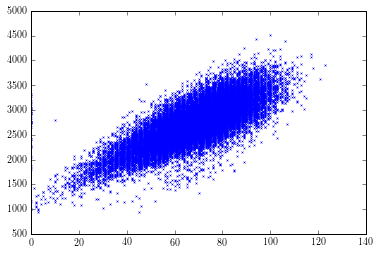

In [359]:
n_skipped = 0
offsets = [0]
for offset in offsets:
    xs, ys = [], []
    for bunchID in tp_data.keys():
        try:
            xs.append(beam_data[bunchID + offset])
            ys.append(tp_data[bunchID]['n_codes'])
        except:
            pass
    print 'Offset %s:'%offset
    pl.plot(xs, ys, 'x', markersize=2)
    pl.show()

In [90]:
img = fn.TimepixFileToImage(tp_datafiles[1])
img = np.asarray(img, dtype=np.float)
print type(img[0][0])

<type 'numpy.float64'>


In [80]:
import scipy.ndimage as ndimage

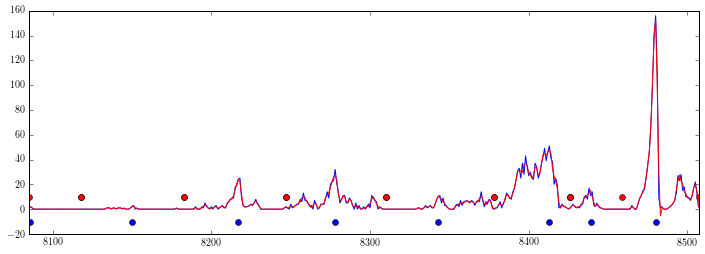

(8085, 8507)

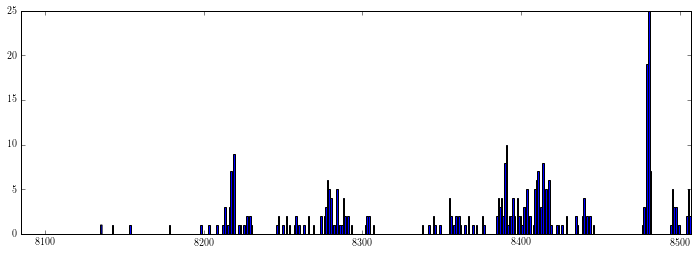

In [281]:
maxval = int(np.max(img)) #get largest timecode
minval = int(np.min(img[img>0])) #get smallest non-zero timecode
# a,b,c =pl.hist(img[img>0],bins = (maxval-minval)+1)
ys = ndimage.histogram(img[img>0],minval,maxval,bins = (maxval-minval)+1) #much faster than pl.hist
xs = np.linspace(minval,maxval,(maxval-minval+1)) #make x points for ToF plot
f = pl.figure(figsize=[12,4]) #Make the figure an appropriate shape
pl.plot(xs,ys,'b') #plot the original ToF
pl.xlim(minval,maxval) #set limits as python is weird sometimes
new_ys = scipy.signal.savgol_filter(ys,5,3) # smooth the ToF as it's only a single shot
pl.plot(xs,new_ys,'r')#plot the new, smoothed ToF
max_indexes = scipy.signal.argrelmax(new_ys, axis=0, order=20) #find local maxima, range of 5 each side
peaks = [xs[_] for _ in max_indexes[0]] # Get peak location from indices

bands = [] # generate banks from peaks - need to take the midpoints though!
bands.append((minval,(peaks[0]+peaks[1])//2)) #first point to midpoint of first peaks
for i in xrange(1,len(peaks)-1):
    bands.append((bands[-1][1],(peaks[i]+peaks[i+1])//2)) # loop through
bands.append((bands[-1][0],maxval))# add last midpoint to last value


pl.plot(peaks,[-10 for _ in max_indexes[0]],'bo') # plot peaks in blue
pl.plot([_[0] for _ in bands],[10 for _ in bands],'ro') # plot left band boundaries in red
pl.plot([_[1] for _ in bands],[10 for _ in bands],'ro') # plot right band boundaries in red too
pl.show()
   
##########
f = pl.figure(figsize=[12,4]) #Make the figure an appropriate shape
a,b,c = pl.hist(t_centroids,max(t_centroids)-min(t_centroids)+1)
pl.xlim(minval,maxval) #set limits as python is weird sometimes


In [335]:
struct_el=[[0,1,0],[1,1,1],[0,1,0]] # for vertical/horizontal connections only
# struct_el=[[1,1,1],[1,1,1],[1,1,1]] # for including diagonal connections as well

from scipy.ndimage.measurements import center_of_mass, maximum_position

segmentation,segments=scipy.ndimage.label(img,struct_el) # find clusters
print 'Found %s clusters without using band information'%segments

print 'Using %s bands...'%len(bands)
seg_sum = 0
t_centroids = []
for i,(tmin, tmax) in enumerate(bands):
#     if i!=6: continue
    band_img = img.copy() #make a copy
    band_img[band_img > tmax] = 0 #threshold new image
    band_img[band_img <= tmin] = 0

#     f = pl.figure(figsize=[8,8]) 
#     pl.imshow(band_img)
    
    segmentation,segments = scipy.ndimage.label(band_img,struct_el) # find clusters
    CoMs = center_of_mass(band_img, segmentation, [_ for _ in xrange(1,segments+1)])
#     CoMs = maximum_position(band_img, segmentation, [_ for _ in xrange(1,segments+1)])
#     print CoMs
#     index = (np.asarray([_[0] for _ in CoMs]),np.asarray([[_[1] for _ in CoMs]]))
#     codes = img[CoMs]
    for com in CoMs:
        t_centroids.append(img[com])
#     break
#     for clust_num in xrange(1,segments): # cluster 0 = background
#         clust_pix = np.where(segmentation==clust_num)
#         t_centroids.append(np.max(img[clust_pix]))

#     print 'Found %s segs in band %s (%s - %s)'%(segments,i, tmin, tmax)
    seg_sum += segments
#     break

print 'Found %s clusters when using bands'%seg_sum
print t_centroids

Found 193 clusters without using band information
Using 8 bands...
Found 9 clusters when using bands
[8437.0, 8441.0, 8444.0, 8427.0, 8436.0, 8440.0, 8440.0, 8435.0, 8446.0]


/Users/mfisherlevine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<type 'numpy.int32'>


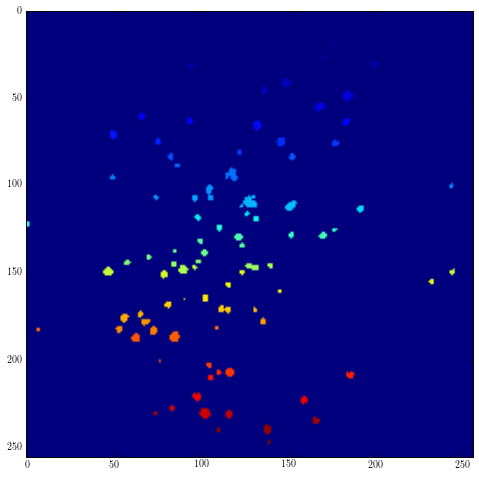

In [283]:
f = pl.figure(figsize=[8,8]) 

pl.imshow(segmentation)
print type(segmentation[0][0])

In [389]:
# struct_el=[[0,1,0],[1,1,1],[0,1,0]] # for vertical/horizontal connections only
# # struct_el=[[1,1,1],[1,1,1],[1,1,1]] # for including diagonal connections as well

# # import scipy.ndimage.measurements.center_of_mass as center_of_mass

# segmentation,segments=scipy.ndimage.label(img,struct_el) # find clusters
# print 'Found %s clusters without using band information'%segments

# print 'Using %s bands...'%len(bands)
# seg_sum = 0
# t_centroids = []
# now = time.time()
# for filename in tp_datafiles[0:100]:
#     for i,(tmin, tmax) in enumerate(bands):
#         band_img = img.copy() #make a copy
#         band_img[band_img > tmax] = 0 #threshold new image
#         band_img[band_img <= tmin] = 0

#         segmentation,segments=scipy.ndimage.label(band_img,struct_el) # find clusters
#         for clust_num in xrange(1,segments): # cluster 0 = background
#             clust_pix = np.where(segmentation==clust_num)
#             t_centroids.append(np.max(img[clust_pix]))
        
#     #     print 'Found %s segs in band %s (%s - %s)'%(segments,i, tmin, tmax)
#         seg_sum += segments
# print 'Time = %s secs'%(time.time()-now)
# print 'Found %s clusters when using bands'%seg_sum
# # print t_centroids

###########

struct_el=[[0,1,0],[1,1,1],[0,1,0]] # for vertical/horizontal connections only
# struct_el=[[1,1,1],[1,1,1],[1,1,1]] # for including diagonal connections as well

# import scipy.ndimage.measurements.center_of_mass as center_of_mass

segmentation,segments=scipy.ndimage.label(img,struct_el) # find clusters
print 'Found %s clusters without using band information'%segments

print 'Using %s bands...'%len(bands)
seg_sum = 0
t_centroids = []
now = time.time()
for filenum, filename in enumerate(tp_datafiles):
    if filenum%1000==0: print 'Processed %s files'%filenum
    img = fn.TimepixFileToImage(filename)
    for i,(tmin, tmax) in enumerate(bands):
        band_img = img.copy() #make a copy
        band_img[band_img > tmax] = 0 #threshold new image
        band_img[band_img <= tmin] = 0

        segmentation,segments = scipy.ndimage.label(band_img,struct_el) # find clusters
#         CoMs = center_of_mass(band_img, segmentation, [_ for _ in xrange(1,segments+1)])
        CoMs = maximum_position(band_img, segmentation, [_ for _ in xrange(1,segments+1)])
        for com in CoMs:
            t_centroids.append(img[com])
        seg_sum += segments

print 'Time = %s secs'%(time.time()-now)
print 'Found %s clusters when using bands'%seg_sum


Found 150 clusters without using band information
Using 8 bands...
Processed 0 files
Processed 1000 files
Processed 2000 files
Processed 3000 files
Processed 4000 files
Processed 5000 files
Processed 6000 files
Processed 7000 files
Processed 8000 files
Processed 9000 files
Processed 10000 files
Processed 11000 files
Processed 12000 files


KeyboardInterrupt: 

3545868
As a histogram:


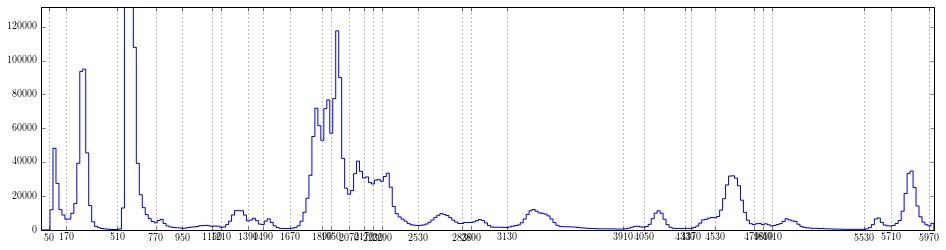

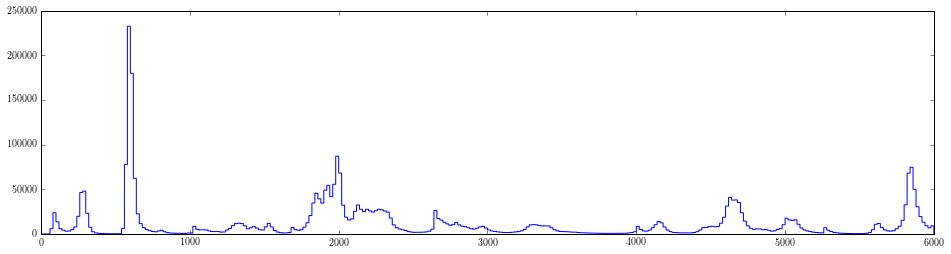

In [390]:
fig = pl.figure(figsize=[16,4])
ax = pl.subplot(111)
print len(t_centroids)
print 'As a histogram:'
ys, binEdges, dummy = pl.hist(all_ts, bins=bins, range=range, histtype = 'step')
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
turn_cent, stat_cent, troughs_cent, peaks_cent = fn.GetTurningPoints(ys, bincenters, noise=50)
lims = pl.ylim()
pl.ylim([lims[0], y_rescale*max(ys)])
ax.set_xticks(troughs_cent, minor=False)
ax.xaxis.grid(True, which='major')
pl.show()

fig = pl.figure(figsize=[16,4])
pl.hist([((11810-_-TZERO)*20) for _ in t_centroids], bins, range=range, histtype = 'step')

pl.show()

In [339]:
clusters = segmentation.copy() # make a copy to preserve original image
for i in xrange(1,segments+1):# loop over clusters
    clusters[clusters==i]=np.random.randint(0,segments+1) #colour each cluster a random colour
clusters[clusters==0]=np.nan #for a white background

ValueError: cannot convert float NaN to integer

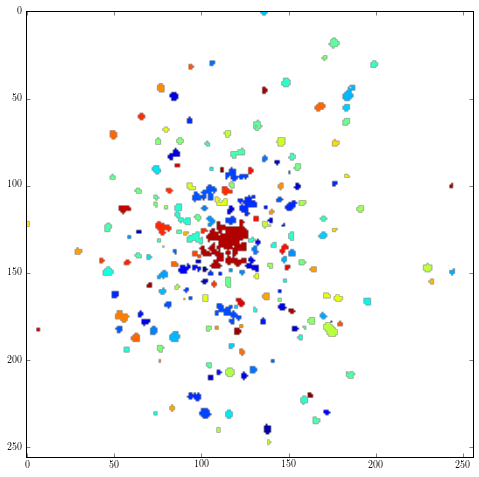

In [121]:
f = pl.figure(figsize=[8,8])
pl.imshow(clusters)

/Users/mfisherlevine/Desktop/desy/Data/Run21/a_2015_12_21_14_38_53_147.txt
Auto vmin = 8085.0


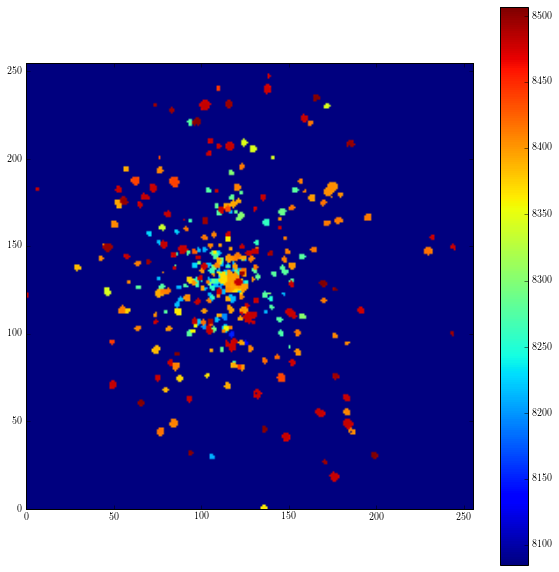

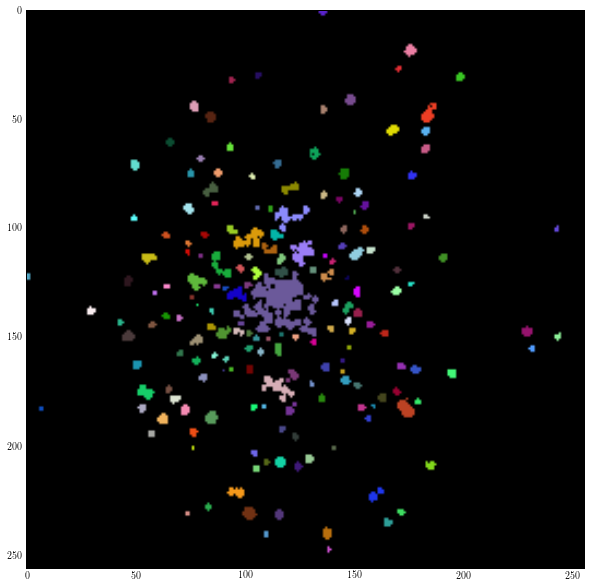

In [28]:
fn = reload(fn)
TCUT = 8000
print tp_datafiles[0]

fn.ShowClusteredImage(tp_datafiles[1],TCUT)

In [368]:
print 'hello'

hello


In [ ]:
fn = reload(fn)
import cPickle as pickle

# NB These are different units!
TCUT = 257 #Raw timecode cut for centroiding
TZERO = 3300 #Time, in ns, after inversion and conversion, to set as t0

run_id = '%s_tcut%s_tzero%s'%(RUN, TCUT, TZERO)
pickle_filename = '/Users/mfisherlevine/Desktop/desy/pickles/tp_data_run'+run_id+'.pickle'

now = time.time()
# if False:
if not os.path.exists(pickle_filename):
    for i, bunchID in enumerate(tp_data.keys()):
    #     if 'ts' in tp_data[bunchID].keys(): continue #already loaded
        if i%100==0:print 'Centroided %s frames'%i; sys.stdout.flush()

        filename = tp_data[bunchID]['filename']
        dummy, xs, ys, ts, npixs = fn.GetCentroidsXYTFromFile(filename, TCUT)#, gating=[8400,8])
        tp_data[bunchID]['xs'] = xs
        tp_data[bunchID]['ys'] = ys
        tp_data[bunchID]['ts'] = [(_-TZERO)*20 for _ in ts]#already inverted, just translate to ns
        tp_data[bunchID]['npixs'] = npixs
        tp_data[bunchID]['n_ions'] = len(xs)

    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(tp_data, pickle_file)
    pickle_file.close()
    print 'Took %s secs'%(time.time() - now)

else:
    print 'Unpickling...'; sys.stdout.flush()
#     pickle_filename = '/Users/mfisherlevine/Desktop/desy/pickles/tp_data_run'+str(RUN)+'.pickle'
    pickle_file = open(pickle_filename, 'rb')
    tp_data = pickle.load(pickle_file)
    pickle_file.close()
    print 'Loaded %s pickled entries'%len(tp_data)


In [369]:
# Put all the centroided timecodes in a single list for convenience
all_ts = []
n_loaded = 0
for bunchID in tp_data.keys():
    if 'ts' in tp_data[bunchID].keys():
        all_ts.extend(tp_data[bunchID]['ts'])
        n_loaded += 1
print 'Collated centroided timecodes from %s shots'%n_loaded
print '%s times in total'%len(all_ts)

Collated centroided timecodes from 24968 shots
4071722 times in total


Offset 0:


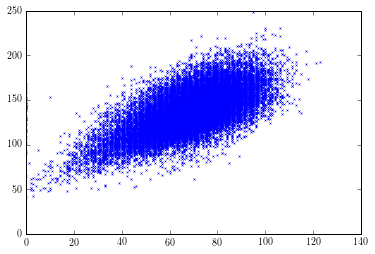

In [362]:
n_skipped = 0
offsets = [0]
for offset in offsets:
    xs, ys = [], []
    for bunchID in tp_data.keys():
        try:
            ys.append(tp_data[bunchID]['n_ions']) #NB has to be this one first due to dropped frames
            xs.append(beam_data[bunchID + offset])
        except Exception as e:
            pass
    print 'Offset %s:'%offset
    pl.plot(xs, ys, 'x', markersize=2)
    pl.show()

In [12]:
# Load the raw timecodes, converting the same way as the others
raw_timecodes = []
for i, filename in enumerate(tp_datafiles):
    if i==1000: print 'Loaded %s files'%i; sys.stdout.flush()
    raw_timecodes.extend(((11810-_)-TZERO)*20 for _ in fn.GetTimecodes_SingleFile(filename, skiplines=1))
print 'Loaded %s raw timecodes'%len(raw_timecodes)

Loaded 1000 files
Loaded 68454234 raw timecodes


Raw timecodes a histogram:


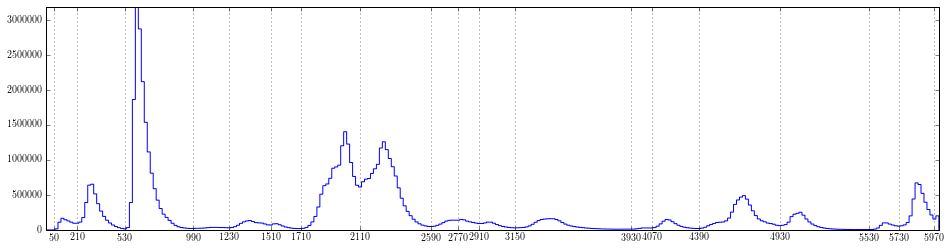

As a histogram:


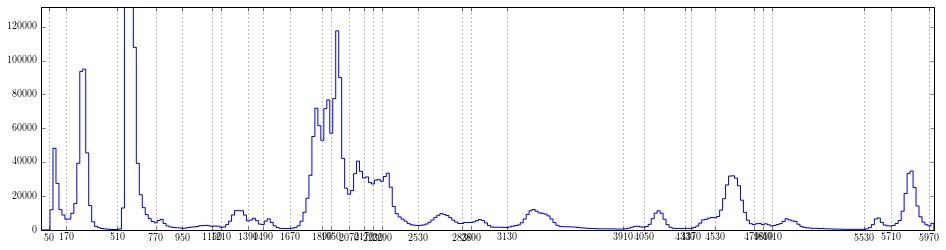

As a line graph:


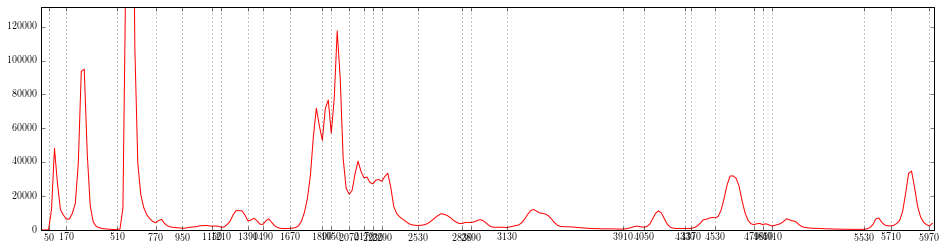

In [370]:
# range = [0,9000]
range = [0,6000]
# range = [4000,5000]

############
# for the raw spectrum:

y_rescale = 1 # big peak is too big, so clip y-axis by rescaling to this fraction of max
bins = min(int((max(raw_timecodes)-min(raw_timecodes)+1)),(range[1]-range[0]+1))//20

fig = pl.figure(figsize=[16,4])
ax = pl.subplot(111)

# as a hist
print 'Raw timecodes a histogram:'
ys, binEdges, dummy = pl.hist(raw_timecodes, bins=bins, range=range, histtype = 'step')
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
lims = pl.ylim()
pl.ylim([lims[0], y_rescale*max(ys)])
# ax.set_xticks(ticks, minor=False)
turn_raw, stat_raw, troughs_raw, peaks_raw = fn.GetTurningPoints(ys, bincenters, noise=500)
ax.set_xticks(troughs_raw, minor=False)
ax.xaxis.grid(True, which='major')
pl.show()


############
# for the centroided spectrum:

y_rescale = 0.3 # big peak is too big, so clip y-axis by rescaling to this fraction of max
bins = min(int((max(all_ts)-min(all_ts)+1)),(range[1]-range[0]+1))//20

fig = pl.figure(figsize=[16,4])
ax = pl.subplot(111)

# as a hist
print 'As a histogram:'
ys, binEdges, dummy = pl.hist(all_ts, bins=bins, range=range, histtype = 'step')
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
turn_cent, stat_cent, troughs_cent, peaks_cent = fn.GetTurningPoints(ys, bincenters, noise=50)
lims = pl.ylim()
pl.ylim([lims[0], y_rescale*max(ys)])
ax.set_xticks(troughs_cent, minor=False)
ax.xaxis.grid(True, which='major')
pl.show()

# as a line graph
print 'As a line graph:'
fig = pl.figure(figsize=[16,4])
ax = pl.subplot(111)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
a = pl.plot(bincenters, ys,'r-')
lims = pl.ylim()
pl.ylim([lims[0], y_rescale*max(ys)])
minor_spacing = 200
xlims = pl.xlim()
# ticks = [_ * minor_spacing for _ in xrange(int(xlims[1]-xlims[0])//minor_spacing)]
ax.set_xticks(troughs_cent, minor=False)
ax.xaxis.grid(True, which='major')
pl.show()
# ax.set_autoscale_on(False)



In [14]:
bands = []
for i in xrange(len(troughs_cent)-1):
    bands.append((troughs_cent[i],troughs_cent[i+1]))
print bands

[(50.0, 170.0), (170.0, 510.0), (510.0, 770.0), (770.0, 950.0), (950.0, 1030.0), (1030.0, 1150.0), (1150.0, 1210.0), (1210.0, 1390.0), (1390.0, 1490.0), (1490.0, 1650.0), (1650.0, 1890.0), (1890.0, 1950.0), (1950.0, 2070.0), (2070.0, 2150.0)]


In [15]:
if RUN==10:
    bands = [( 30.0, 140.0), 
             (140.0, 500.0),
             (500.0, 750.0),
             (750.0, 1490.0),
             (1490.0, 1710.0),
             (1710.0, 1870.0),
             (1870.0, 1950.0),
             (1950.0, 2070.0),
             (2070.0, 2210.0),
             (2210.0, 2650.0),
             (2650.0, 2750.0),
             (2750.0, 2810.0),
             (2810.0, 2950.0),
             (2950.0, 3210.0),
             (3210.0, 3490.0),
             (3490.0, 3930.0),
             (3930.0, 4070.0),
             (4070.0, 4370.0),
             (4370.0, 4510.0),
             (4510.0, 4790.0),
             (4790.0, 4830.0),
             (4830.0, 4910.0),
             (4910.0, 5030.0),
             (5030.0, 5530.0),
             (5530.0, 5710.0),
             (5710.0, 5970.0)]

# grab the first of each of these tuples, and append the last to get back the edges
band_edges = [_[0] for _ in bands]; band_edges.append(bands[-1][1])
print band_edges

[50.0, 170.0, 510.0, 770.0, 950.0, 1030.0, 1150.0, 1210.0, 1390.0, 1490.0, 1650.0, 1890.0, 1950.0, 2070.0, 2150.0]


As a histogram:


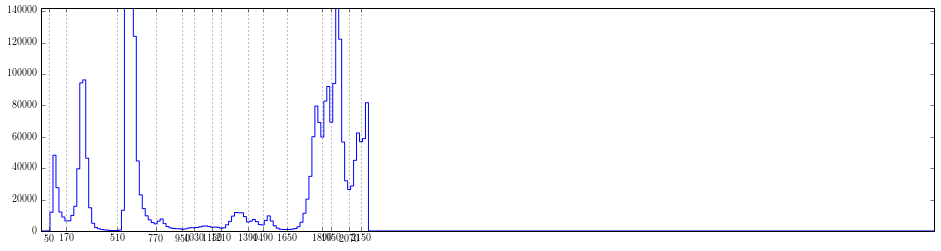

[50.0, 170.0, 510.0, 770.0, 950.0, 1030.0, 1150.0, 1210.0, 1390.0, 1490.0, 1650.0, 1890.0, 1950.0, 2070.0, 2150.0]


In [16]:
# range = [0,9000]
range = [0,6000]

############
# for the centroided spectrum:

y_rescale = 0.3 # big peak is too big, so clip y-axis by rescaling to this fraction of max
bins = min(int((max(all_ts)-min(all_ts)+1)),(range[1]-range[0]+1))//20

fig = pl.figure(figsize=[16,4])
ax = pl.subplot(111)

# as a hist
print 'As a histogram:'
ys, binEdges, dummy = pl.hist(all_ts, bins=bins, range=range, histtype = 'step')
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
lims = pl.ylim()
pl.ylim([lims[0], y_rescale*max(ys)])
ax.set_xticks(band_edges, minor=False)
ax.xaxis.grid(True, which='major')
pl.show()

#### as a line graph
# print 'As a line graph:'
# fig = pl.figure(figsize=[16,4])
# ax = pl.subplot(111)
# bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
# a = pl.plot(bincenters, ys,'r-')
# lims = pl.ylim()
# pl.ylim([lims[0], y_rescale*max(ys)])
# minor_spacing = 200
# xlims = pl.xlim()
### ticks = [_ * minor_spacing for _ in xrange(int(xlims[1]-xlims[0])//minor_spacing)]
# ax.set_xticks(band_edges, minor=False)
# ax.xaxis.grid(True, which='major')
# pl.show()
# # ax.set_autoscale_on(False)
print band_edges

Band = 50.0 - 170.0:


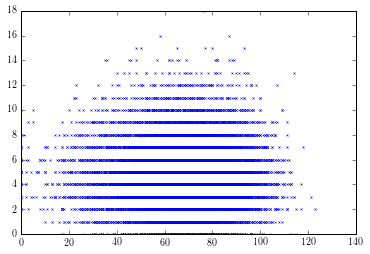

Band = 170.0 - 510.0:


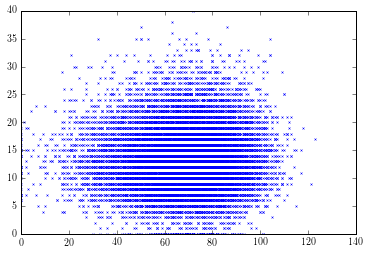

Band = 510.0 - 770.0:


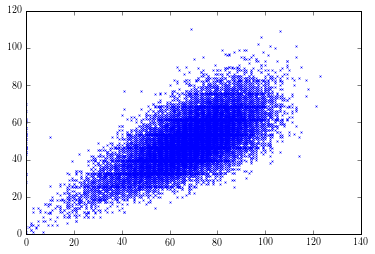

Band = 770.0 - 950.0:


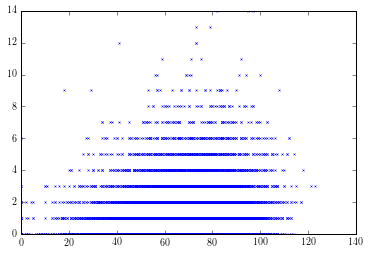

Band = 950.0 - 1030.0:


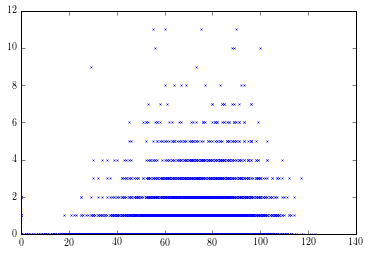

Band = 1030.0 - 1150.0:


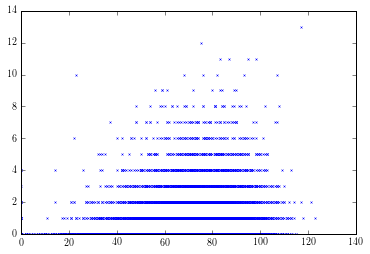

Band = 1150.0 - 1210.0:


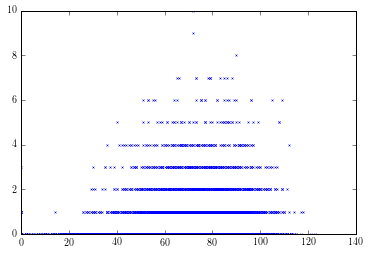

Band = 1210.0 - 1390.0:


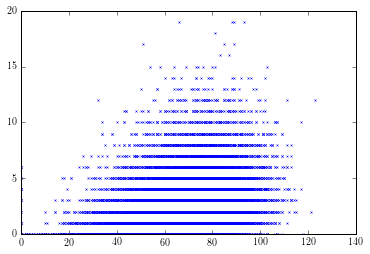

Band = 1390.0 - 1490.0:


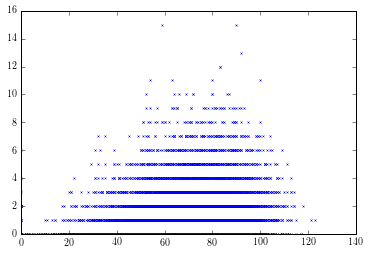

Band = 1490.0 - 1650.0:


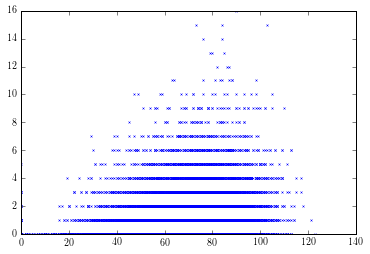

Band = 1650.0 - 1890.0:


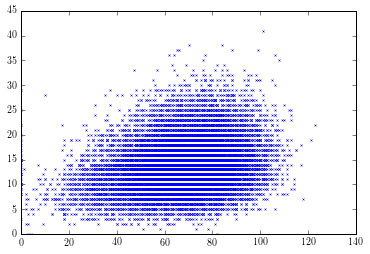

Band = 1890.0 - 1950.0:


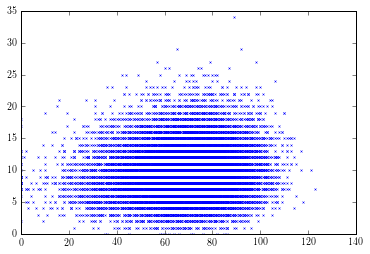

Band = 1950.0 - 2070.0:


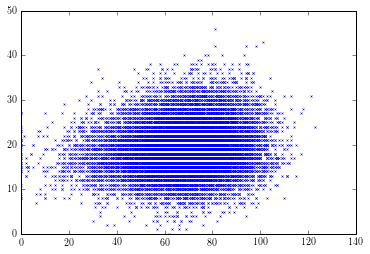

Band = 2070.0 - 2150.0:


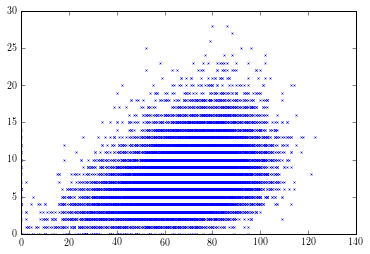

In [17]:
n_skipped = 0
for t_range in bands:
    xs, ys = [], []
    for bunchID in tp_data.keys():
        try:
            n_in_range = 0
            for t in tp_data[bunchID]['ts']:
                if t>= t_range[0] and t < t_range[1]:
                    n_in_range += 1
            ys.append(n_in_range) #NB has to be this one first due to dropped frames
            xs.append(beam_data[bunchID])
        except Exception as e:
            pass
    print 'Band = %s - %s:'%(t_range[0], t_range[1])
    pl.plot(xs, ys, 'x', markersize=2)
    pl.show()

In [18]:
#probably don't need to rerun this, and it takes ages, so don't do it by accident:
if True: 
    import time
    now = time.time()
    n_bunches = 999999

    images = [np.zeros((256,256), dtype = np.float64) for _ in bands]
    for i, t_range in enumerate(bands):
        print 'Processing band %s of %s'%(i+1, len(bands))
        for bunchID in sorted(tp_data.keys())[:min(n_bunches,tp_data.keys())]:
            for x,y,t,npix in zip(tp_data[bunchID]['xs'],
                                  tp_data[bunchID]['ys'],
                                  tp_data[bunchID]['ts'],
                                  tp_data[bunchID]['npixs']):
                if t >= t_range[0] and t<t_range[1]:
        #             image += makeGaussian(256,1,1.5,[x,y])
                    images[i] += fn.makeGaussian(256,1,(npix**.5)/1.5,[x,y])
    print 'Took %.1f secs'%(time.time()-now)
# ### The un-debugged version that doesn't nest the loops backwards, but also doens't run faster
# import time
# n_bunches = 1000

# outside_range = np.zeros((256,256), dtype = np.float64)
# images = [np.zeros((256,256), dtype = np.float64) for _ in bands]

# now = time.time()
# for bunchID in sorted(tp_data.keys())[:min(n_bunches,tp_data.keys())]:
#     for x,y,t,npix in zip(tp_data[bunchID]['xs'],
#                           tp_data[bunchID]['ys'],
#                           tp_data[bunchID]['ts'],
#                           tp_data[bunchID]['npixs']):
#         found_band = False
#         for i, band in enumerate(bands):
#             if t >= band[0] and t<band[1]:
# #             image += makeGaussian(256,1,1.5,[x,y])
#                 images[i] += fn.makeGaussian(256,1,(npix**.5)/1.5,[x,y])
#                 found_band = True
#             break
#         if found_band == False:
#             outside_range += fn.makeGaussian(256,1,(npix**.5)/1.5,[x,y])
# print 'Took %.1f secs'%(time.time()-now)

Processing band 1 of 14
Processing band 2 of 14
Processing band 3 of 14


KeyboardInterrupt: 

In [ ]:
#### pickle the bands and their images
pickle_filename = '/Users/mfisherlevine/Desktop/desy/pickles/run'+run_id+'_VMIs.pickle'

if False: #C areful, this will overwrite the good pickles if you accidentally run it!
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump([bands, images], pickle_file)
    pickle_file.close()


#### Load the bands and their images from the pickle:
if True:
    print 'Unpickling...'; sys.stdout.flush()
    pickle_file = open(pickle_filename, 'rb')
    [bands, images] = pickle.load(pickle_file)
    pickle_file.close()
    print 'Loaded bands and images'

In [ ]:
print bands

In [ ]:
fn = reload(fn)
cmap = 'copper' ### beware using the de facto standard 'jet',
                ### but it's also replotted below for people who can't live without it
for i, image in enumerate(images):
    title = 'VMI for times %s to %s (band #%s)'%(bands[i][0],bands[i][1], i)
    fn.DisplayImage(image, cmap=cmap, title=title,vmax='auto')
    pl.show()
    

In [ ]:
fn = reload(fn)
cmap = 'jet'
for i, image in enumerate(images):
    title = 'VMI for times %s to %s (band %s)'%(bands[i][0],bands[i][1], i)
    fn.DisplayImage(image, cmap=cmap, title=title,vmax='auto')
    pl.show()

In [ ]:
cmap = 'jet'
image = images[27].copy()
fn.DisplayImage(image, cmap=cmap, title=title,vmax='auto')
pl.show()

import scipy.ndimage as im_process
from scipy.ndimage.filters import gaussian_filter


deriv = im_process.sobel(gaussian_filter(image,3), mode='constant')
fn.DisplayImage(deriv, cmap=cmap, title=title,vmax='auto')
pl.show()

deriv[abs(deriv)<10]=0
fn.DisplayImage(deriv, cmap=cmap, title=title,vmax='auto')
pl.show()

deriv=abs(deriv/abs(deriv))
fn.DisplayImage(deriv, cmap=cmap, title=title)
pl.show()



In [ ]:
from skimage import feature

fn = reload(fn)
cmap = 'jet'
for i, image in enumerate(images):
    image = image.copy()
    if i!=27: continue
#     title = 'Fit to VMI for times %s to %s (band %s)'%(bands[i][0],bands[i][1], i)
    title = 'Band %s'%i

    fn.DisplayImage(image, cmap=cmap, title=title,vmax='auto')
#     image[image < 0.8*np.max(image)] = 0
    image[image < np.percentile(image,97)] = 0

    pl.show()
    
#     edges = feature.canny(image, sigma=3)

    edges = feature.blob_dog(image)
    fn.DisplayImage(edges, cmap=cmap, title=title)
    pl.show()

#     feature.
#     x,y,r = FitCircle(deriv)
#     DisplayImageWithFit(deriv,x,y,r,title=title)
    
#     pl.show()

In [ ]:
fn = reload(fn)
cmap = 'jet'
for i, image in enumerate(images):
#     if i!=3: continue
#     title = 'Fit to VMI for times %s to %s (band %s)'%(bands[i][0],bands[i][1], i)
    title = 'Band %s'%i

    fn.DisplayImage(image, cmap=cmap, title=title,vmax='auto')
    import scipy.ndimage as im_process
    from scipy.ndimage.filters import gaussian_filter

    deriv = im_process.laplace(gaussian_filter(image,2), mode='constant')
#     title += ' gaus, laplace'
#     fn.DisplayImage(deriv, cmap=cmap, title=title)
#     pl.show()

    deriv[deriv < np.percentile(deriv,99.7)] = 0

    title += ' 99.7th percentile cut'
    fn.DisplayImage(deriv, cmap=cmap, title=title)
    pl.show()

    deriv=abs(deriv/abs(deriv))
#     title += ', normed'
#     fn.DisplayImage(deriv, cmap=cmap, title=title)
#     pl.show()

    x,y,r = FitCircle(deriv)
    DisplayImageWithFit(deriv,x,y,r,title=title)
    
    pl.show()

In [ ]:
x,y,r = FitCircle(deriv)
x_circ, y_circ = MakeCirlePointsFromXYR(x,y,r)

In [ ]:
def MakeCirlePointsFromXYR(x, y, r, npts=180):
    theta_fit = np.linspace(-np.pi, np.pi, npts)
    xs = x + r*np.cos(theta_fit)
    ys = y + r*np.sin(theta_fit)
    return xs, ys

In [ ]:
fig = pl.figure(figsize = [10,10])
ax = fig.add_subplot(111)
# ax.set_xlim([YMIN,YMAX])
# ax.set_ylim([XMIN,XMAX])

# if vmax == 'auto':
#     element = (256*256) - 200
#     tmp = image.flatten()
#     tmp.sort()
#     vmax = tmp[element]
#     vmin = tmp[200]
#     print 'Auto vmax = %s, real max = %s'%(vmax, np.max(image))

# if vmin == 'auto':
#     tmp = image.flatten()
#     vmin = min(_ for _ in tmp if _ > 0)
#     print 'Auto vmin = %s'%vmin

im = ax.imshow(deriv)#, vmin=vmin, vmax=vmax, cmap=cmap)
pl.plot(y,x, 'x', ms=15)
pl.plot(y_circ, x_circ, 'r-.')#, label=method_3, lw=2)
ax.set_title(title)
fig.colorbar(im)


In [ ]:
def DisplayImageWithFit(image, x, y, r, vmin=None, vmax=None, cmap='jet', title = ''):
    import numpy as np
    fig = pl.figure(figsize = [10,10])
    ax = fig.add_subplot(111)
    ax.set_xlim([0,255])
    ax.set_ylim([0,255])

    if vmax == 'auto':
        element = (256*256) - 200
        tmp = image.flatten()
        tmp.sort()
        vmax = tmp[element]
        vmin = tmp[200]
        print 'Auto vmax = %s, real max = %s'%(vmax, np.max(image))

    if vmin == 'auto':
        tmp = image.flatten()
        vmin = min(_ for _ in tmp if _ > 0)
        print 'Auto vmin = %s'%vmin

    im = ax.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap)
    
    pl.plot(y,x, 'xb', ms=15) # x on the centre
    x_circ, y_circ = MakeCirlePointsFromXYR(x,y,r) #generate circle points
    pl.plot(y_circ, x_circ, 'r-.', lw=4) #plot circle
    ax.set_title(title)
    fig.colorbar(im)
    return im

In [ ]:
def FitCircle(data):
    import numpy as np
    from scipy import odr

    x,y = np.where(data>=0)
#     x = np.r_[  9, 35, -13,  10,  23,   0]
#     y = np.r_[ 34, 10,   6, -14,  27, -10]
    
    x_m = np.mean(x)
    y_m = np.mean(y)
    
    method_3  = "odr"

    import functools
    def countcalls(fn):
        "decorator function count function calls "

        @functools.wraps(fn)
        def wrapped(*args):
            wrapped.ncalls +=1
            return fn(*args)

        wrapped.ncalls = 0
        return wrapped
    
    @countcalls
    def calc_R(xc, yc):
        """ calculate the distance of each 2D points from the center (xc, yc) """
        return np.sqrt((x-xc)**2 + (y-yc)**2)

    @countcalls
    def f_3(beta, x):
        """ implicit definition of the circle """
        return (x[0]-beta[0])**2 + (x[1]-beta[1])**2 -beta[2]**2

    # initial guess for parameters
    R_m = calc_R(x_m, y_m).mean()
    beta0 = [ x_m, y_m, R_m]

    # for implicit function :
    #       data.x contains both coordinates of the points
    #       data.y is the dimensionality of the response
    lsc_data   = odr.Data(np.row_stack([x, y]), y=1)
    lsc_model  = odr.Model(f_3, implicit=True)
    lsc_odr    = odr.ODR(lsc_data, lsc_model, beta0)
    lsc_out    = lsc_odr.run()

    xc_3, yc_3, R_3 = lsc_out.beta
    Ri_3       = calc_R(xc_3, yc_3)
    residu_3   = sum((Ri_3 - R_3)**2)
    residu2_3  = sum((Ri_3**2-R_3**2)**2)
    ncalls_3   = f_3.ncalls

    # == METHOD 3b ==
    # Advanced usage, with jacobian
    method_3b  = "odr with jacobian"
    print "\nMethod 3b : ", method_3b

    @countcalls
    def f_3b(beta, x):
        """ implicit definition of the circle """
        return (x[0]-beta[0])**2 + (x[1]-beta[1])**2 -beta[2]**2

    @countcalls
    def jacb(beta, x):
        """ Jacobian function with respect to the parameters beta.
        return df_3b/dbeta
        """
        xc, yc, r = beta
        xi, yi    = x

        df_db    = np.empty((beta.size, x.shape[1]))
        df_db[0] =  2*(xc-xi)                     # d_f/dxc
        df_db[1] =  2*(yc-yi)                     # d_f/dyc
        df_db[2] = -2*r                           # d_f/dr

        return df_db

    @countcalls
    def jacd(beta, x):
        """ Jacobian function with respect to the input x.
        return df_3b/dx
        """
        xc, yc, r = beta
        xi, yi    = x

        df_dx    = np.empty_like(x)
        df_dx[0] =  2*(xi-xc)                     # d_f/dxi
        df_dx[1] =  2*(yi-yc)                     # d_f/dyi

        return df_dx


    def calc_estimate(data):
        """ Return a first estimation on the parameter from the data  """
        xc0, yc0 = data.x.mean(axis=1)
        r0 = np.sqrt((data.x[0]-xc0)**2 +(data.x[1] -yc0)**2).mean()
        return xc0, yc0, r0

    # for implicit function :
    #       data.x contains both coordinates of the points
    #       data.y is the dimensionality of the response
    lsc_data  = odr.Data(np.row_stack([x, y]), y=1)
    lsc_model = odr.Model(f_3b, implicit=True, estimate=calc_estimate, fjacd=jacd, fjacb=jacb)
    lsc_odr   = odr.ODR(lsc_data, lsc_model)    # beta0 has been replaced by an estimate function
    lsc_odr.set_job(deriv=3)                    # use user derivatives function without checking
    lsc_odr.set_iprint(iter=1, iter_step=1)     # print details for each iteration
    lsc_out   = lsc_odr.run()

    xc_3, yc_3, R_3 = lsc_out.beta
    Ri_3       = calc_R(xc_3, yc_3)
    residu_3   = sum((Ri_3 - R_3)**2)
    residu2_3  = sum((Ri_3**2-R_3**2)**2)
    ncalls_3   = f_3.ncalls

    print "\nFunctions calls : f_3b=%d jacb=%d jacd=%d" % (f_3b.ncalls, jacb.ncalls, jacd.ncalls)

    
#     def PlotAll():
#         f = pl.figure( facecolor='white')  #figsize=(7, 5.4), dpi=72,
#         pl.axis('equal')

#         theta_fit = np.linspace(-np.pi, np.pi, 180)

#         x_fit3 = xc_3 + R_3*np.cos(theta_fit)
#         y_fit3 = yc_3 + R_3*np.sin(theta_fit)
#         pl.plot(x_fit3, y_fit3, 'r-.', label=method_3, lw=2)

#         pl.plot(xc_3, yc_3, 'x', ms=10)
        
#         pl.plot(x, y, 'o', label='data', ms=3)#, mec='b', mew=1)
#         pl.show()
    
#     PlotAll()

    return xc_3, yc_3, R_3

        
FitCircle(deriv)


In [ ]:
# Snippet for examples of annotating images (not mine):

# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt

fig = plt.figure()
fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('axes title')

ax.set_xlabel('xlabel')
ax.set_ylabel('ylabel')

ax.text(3, 8, 'boxed italics text in data coords', style='italic',
        bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

ax.text(2, 6, r'an equation: $E=mc^2$', fontsize=15)

# ax.text(3, 2, u'unicode: Institut f\374r Festk\366rperphysik')

ax.text(0.95, 0.01, 'colored text in axes coords',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='green', fontsize=15)


ax.plot([2], [1], 'o')
ax.annotate('annotate', xy=(2, 1), xytext=(3, 4),
            arrowprops=dict(facecolor='black', shrink=0.05))

ax.axis([0, 10, 0, 10])

plt.show()

In [ ]:
# Snippet to text out luminance balancing of colour maps:
image = np.zeros((256,256), dtype = np.float)
a = fn.makeGaussian(256,1500,50,[100,100])
image += a
print np.max(a)
fn.DisplayImage(image, cmap='jet')
fn.DisplayImage(image, cmap='gray')
fn.DisplayImage(image, cmap='winter')
fn.DisplayImage(image, cmap='cubehelix')

In [ ]:
#     PEAK_SETTINGS_CENTROIDED = {}
#     PEAK_SETTINGS_CENTROIDED['vector'] = global_TOF_centroided
#     PEAK_SETTINGS_CENTROIDED['widths'] = np.asarray([3])
#     PEAK_SETTINGS_CENTROIDED['min_snr']    = [0.015]
#     PEAK_SETTINGS_CENTROIDED['noise_perc'] = [0.0001]

#     peaks_centroided = findpeaks( **PEAK_SETTINGS_CENTROIDED)

#     if fig is None:
#         print 'declared new fig'
#         fig = pl.figure(figsize=[16,8])
#     ax_cent = pl.subplot(212)
#     ax_raw  = pl.subplot(211, sharex=ax_cent)
#     tof1 = ax_cent.plot(range(11810),global_TOF_centroided)
#     tof2 =  ax_raw.plot(range(11810),global_TOF)
#     ax_cent.set_ylim([0,max(global_TOF_centroided[TOF_TMIN:TOF_TMAX])])
#     ax_raw.set_ylim([0,max(global_TOF[TOF_TMIN:TOF_TMAX])])
#     ax_cent.set_xlim([TOF_TMIN,TOF_TMAX])
#     ax_raw.set_xlim([TOF_TMIN,TOF_TMAX])
#     if flip:
#         ax_cent.set_xlim(ax_cent.get_xlim()[::-1])
#     ax_cent.set_title('ToF Centroided')

#     FilterPeaks()
#     print 'Centroided peaks found at %s'%peaks_centroided[::-1]
#     print '       Raw peaks found at %s'%peaks_raw[::-1]

#     if ax_cent is not None:
#         for peak in peaks_centroided:
#             ax_cent.plot([peak, peak], [0, ax_cent.get_ylim()[1]], color='k', linestyle='--', linewidth=1)

#     for peak in peaks_raw:
#         ax_raw.plot([peak, peak], [0, ax_raw.get_ylim()[1]], color='k', linestyle='--', linewidth=1)

#     ax_raw.set_title('ToF RAW')

# #     f.savefig(out_path + 'ToF.png')
#     pl.show()

#     return ax_raw, ax_cent


# def FilterPeaks():
#     import operator
#     search_range = 5
#     cent_threshold = len(tp_data) / 10
#     raw_threshold = len(loaded_fileNAMES) * 2
#     global peaks_centroided
#     global peaks_raw
#     new_peaks_centroided = []
#     new_peaks_raw = []

#     for peak in peaks_centroided:
#         _min = max(peak - search_range, 0)
#         _max = min(peak + search_range, len(global_TOF_centroided))
#         index, maxval = max(enumerate(global_TOF_centroided[_min:_max]), key=operator.itemgetter(1))
#         if maxval >= cent_threshold:
#             new_peaks_centroided.append(_min+index)

#     for peak in peaks_raw:
#         _min = max(peak - search_range, 0)
#         _max = min(peak + search_range, len(global_TOF))
#         index, maxval = max(enumerate(global_TOF[_min:_max]), key=operator.itemgetter(1))
#         if maxval >= raw_threshold:
#             new_peaks_raw.append(_min+index)

#     peaks_centroided = new_peaks_centroided
#     peaks_raw = new_peaks_raw